In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/AUA/AUA 2020 Spring/Deep Learning/DL_HW5')

In [0]:
# import packages
import torch
import matplotlib.pyplot as plt
from reg_utils_Pytorch_final import sigmoid, relu, plot_decision_boundary_2D, initialize_parameters, predict_dec
from reg_utils_Pytorch_final import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases_Pytorch_final import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [0]:
torch.set_default_dtype(torch.float64)
torch.set_printoptions(precision = 12)

In [0]:
def load_2D_dataset():
    data = scipy.io.loadmat('/content/gdrive/My Drive/AUA/AUA 2020 Spring/Deep Learning/DL_HW5/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y.squeeze(), s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

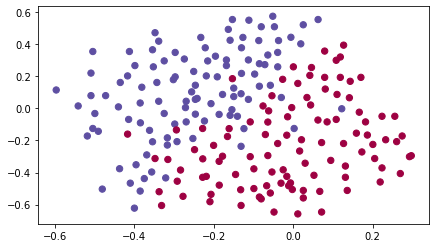

In [0]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [0]:
train_X = torch.from_numpy(train_X)
train_Y = torch.from_numpy(train_Y).to(torch.float64)
test_X = torch.from_numpy(test_X)
test_Y = torch.from_numpy(test_Y).to(torch.float64)

In [0]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    #plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.6557412523481
Cost after iteration 10000: 0.1632998752572418
Cost after iteration 20000: 0.13851642423239902


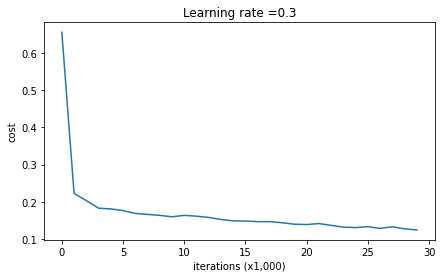

In [0]:
parameters = model(train_X, train_Y)

In [0]:
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

On the training set:
Accuracy: tensor(0.947867298578)
On the test set:
Accuracy: tensor(0.915000000000)


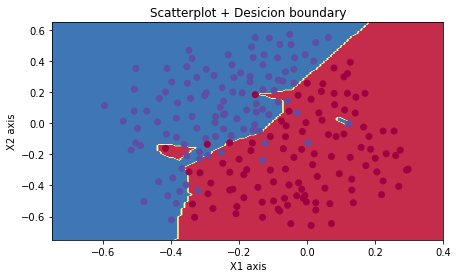

In [0]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary_2D(lambda x: predict_dec(parameters, x), train_X, train_Y)

# L2 Regularization

In [0]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    import numpy as np
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    L2_regularization_cost = lambd / (2 * m) * (torch.sum(torch.pow(W1,2)) + torch.sum(torch.pow(W2,2)) + torch.sum(torch.pow(W3,2))) 
    cost = cross_entropy_cost + L2_regularization_cost

    return cost

In [0]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

In [0]:
print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = tensor(1.786485945159)


In [0]:
def backward_propagation_with_regularization(X, Y, cache, lambd):

    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = dZ3@A2.T/m + lambd / m * W3
    db3 = torch.sum(dZ3, axis=1, keepdims = True)/m
    
    dA2 = W3.T@dZ3
    dZ2 = torch.mul(dA2, (A2 > 0).to(torch.float64))
    dW2 = dZ2@A1.T/m + lambd / m * W2
    db2 = torch.sum(dZ2, axis=1, keepdims = True)/m
    
    dA1 = W2.T@dZ2
    dZ1 = torch.mul(dA1, (A1 > 0).to(torch.float64))
    dW1 = dZ1@X.T/m + lambd / m * W1
    db1 = torch.sum(dZ1, axis=1, keepdims = True)/m
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [0]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

In [0]:
grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
tensor([[-0.256046458323,  0.122988269171, -0.282971287146],
        [-0.177063025831,  0.345360943396, -0.441057102373]])
dW2 = 
tensor([[ 0.792764862343,  0.851339183815],
        [-0.095721900400, -0.017204632200],
        [-0.131007720200, -0.037504331200]])
dW3 = 
tensor([[-1.776913472043, -0.118328789600, -0.093974458200]])


Cost after iteration 0: 0.6974484493131262
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


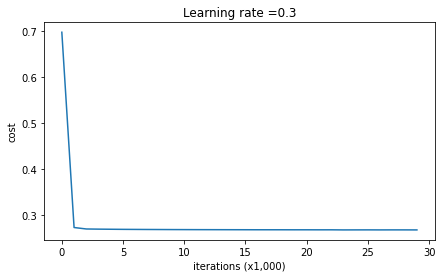

On the train set:


In [0]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")

In [0]:
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Accuracy: tensor(0.938388625592)
On the test set:
Accuracy: tensor(0.930000000000)


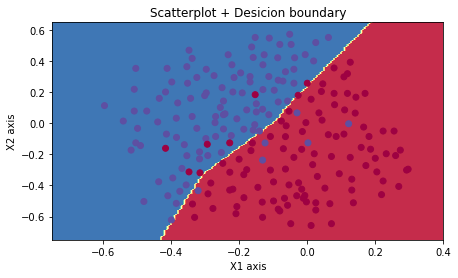

In [0]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary_2D(lambda x: predict_dec(parameters, x), train_X, train_Y)

# Dropout

In [0]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    torch.manual_seed(3)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = W1@X + b1
    A1 = relu(Z1)         
    D1 = D1 = torch.rand(A1.shape[0], A1.shape[1])                     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                               # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1                                      # Step 3: shut down some neurons of A1
    A1 = A1 / keep_prob                                        # Step 4: scale the value of neurons that haven't been shut down
    Z2 = W2@A1 + b2
    A2 = relu(Z2)
    D2 = torch.rand(A2.shape[0], A2.shape[1])                                          # Step 1: initialize matrix D2 = torch.rand(..., ...)
    D2 = D2 < keep_prob                                          # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2 * D2                                          # Step 3: shut down some neurons of A2
    A2 = A2 / keep_prob                                          # Step 4: scale the value of neurons that haven't been shut down
    Z3 = W3@A2 + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [0]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

In [0]:
A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = tensor([[3.697472061782e-01, 2.938155846564e-04, 1.777018442203e-01,
         1.446892814786e-02, 4.968338925884e-01]])


## Backward propagation with dropout

In [0]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = dZ3@A2.T/m
    db3 = torch.sum(dZ3, axis=1, keepdims = True)/m
    dA2 = W3.T@dZ3
    dA2 = dA2 * D2                            # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2 / keep_prob                             # Step 2: Scale the value of neurons that haven't been shut down
    dZ2 = torch.mul(dA2, (A2 > 0).to(torch.int64))
    dW2 = dZ2@A1.T/m
    db2 = torch.sum(dZ2, axis=1, keepdims = True)/m
    
    dA1 = W2.T@dZ2
    dA1 = dA1 * D1                                # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 / keep_prob                                # Step 2: Scale the value of neurons that haven't been shut down
    dZ1 = torch.mul(dA1, (A1 > 0).to(torch.int64))
    dW1 = dZ1@X.T/m
    db1 = torch.sum(dZ1, axis=1, keepdims = True)/m
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [0]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

In [0]:
gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
tensor([[ 0.365444386363,  0.000000000000, -0.001882334950,  0.000000000000,
         -0.174087476688],
        [ 0.655157130426,  0.000000000000, -0.003374590527,  0.000000000000,
         -0.000000000000]])
dA2 = 
tensor([[ 0.581808561447,  0.000000000000, -0.002996785914,  0.000000000000,
         -0.277157313553],
        [ 0.000000000000,  0.531598542536, -0.000000000000,  0.531598542536,
         -0.340896727391],
        [ 0.000000000000,  0.000000000000, -0.002927329545,  0.000000000000,
         -0.000000000000]])


Cost after iteration 0: 0.6539320781219095
Cost after iteration 10000: 0.052430945589745474
Cost after iteration 20000: 0.043591111062223235


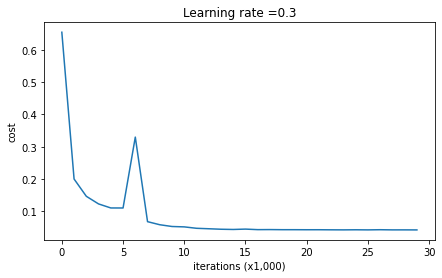

In [0]:
parameters = model(train_X, train_Y, keep_prob = 0.9)

In [0]:
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

#NOTE
#The results are different from the expected output because I have replaced keep_prob's value of 0.88 with 0.9 to have a better train, test aaccuracy. With 0.88 it outputs the exact expected output.

On the train set:
Accuracy: tensor(0.943127962085)
On the test set:
Accuracy: tensor(0.950000000000)


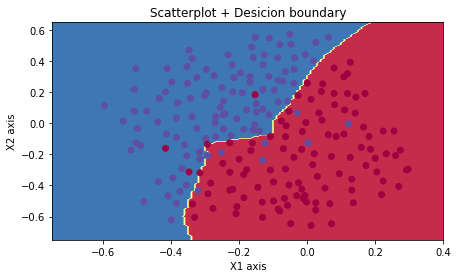

In [0]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary_2D(lambda x: predict_dec(parameters, x), train_X, train_Y)